In [36]:
import os
import requests
import re
import pandas as pd
import logging
import json
import argparse
import glob
import re
import ast
import matplotlib.pyplot as plt

In [37]:
def get_hgnc_complete_list(symbol_json_file='./hgnc_complete_set_2020-10-01.json'):
  # read json from url 
  if not os.path.exists(symbol_json_file):
    logging.info('Downloading HGNC complete list')
    url = "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/archive/quarterly/json/hgnc_complete_set_2020-10-01.json"
    gene_list_json = requests.get(url).json()['response']['docs']
    symbol_list = []
    for item in gene_list_json:
      
      symbol = item.get("symbol", "").upper().replace(" ", "")
      alias_symbol = item.get("alias_symbol", [])
      alias_symbol = [alias.upper().replace(" ", "") for alias in alias_symbol]
      prev_symbol = item.get("prev_symbol", [])
      prev_symbol = [prev.upper().replace(" ", "") for prev in prev_symbol]      
      if symbol != '': 
        symbol_list.append({"symbol": symbol, "other": symbol})
        for alias in alias_symbol:
          symbol_list.append({"symbol": symbol, "other": alias})
        for prev in prev_symbol:
          symbol_list.append({"symbol": symbol, "other": prev})
    logging.info('HGNC complete list downloaded')
    logging.info('length of HGNC complete list: {}'.format(len(symbol_list)))
    with open(symbol_json_file, 'w') as f:
      json.dump(symbol_list, f)
  else:
    with open(symbol_json_file, 'r') as f:
      logging.info('Reading HGNC complete list from local file')
      symbol_list = json.load(f)
      logging.info('length of HGNC complete list: {}'.format(len(symbol_list)))
  return symbol_list

hgnc_complete_list = get_hgnc_complete_list()
hgnc_complete_df = pd.DataFrame(hgnc_complete_list)

In [38]:
mega_list = [['id', 'answer', 'generated_gene_list', 'final_gene_list', 'generated_gene_count', 'gene_count', 'true_genes', 'true_gene_count', 'fake_ratio', 'duplicate_ratio', 'q_a']]

def extract_question(text):
    pattern = "Question: (.*?)(?=Question:|Answer:|$)"
    questions = re.findall(pattern, text, re.DOTALL)
    questions = [question.strip() for question in questions]

    if len(questions) == 1:
        pattern = r'Can you suggest a list of (\d+) possible genes to test?'
        match = re.search(pattern, questions[0])
        if match:
            x = int(match.group(1))
            print(x)
            return x

    
def extract_answer(text, file_name):
    pattern = "Answer: (.*?)(?=Answer:|Question:|$)"
    answers = re.findall(pattern, text, re.DOTALL)
    answers = [answer.strip() for answer in answers]

    # Define a variable to hold the result outside the if condition
    result = None
    generated_genes = []
    genes = []
    true_genes = []
    gene_number = 0
    generated_gene_number = 0
    true_gene_number = 0
    generated_ratio = 0
    fake_ratio = 0
    final_genes = set()


    if len(answers) == 1:
        # Assuming you want to save the answer to a file
        directory_path = "D:/연구/llama2_classified"
        os.makedirs(directory_path, exist_ok=True)  # Ensure the directory exists
        full_file_path = os.path.join(directory_path, f"{file_name}.txt")

        with open(full_file_path, "w") as file:
            file.write(answers[0])
            result = answers[0]

            if "The gene list is:" in result:
                gene_list_pattern = r"The gene list is: ([\w, ]+)"
                match = re.search(gene_list_pattern, result)
                if match:
                    gene_list_str = match.group(1)
                    generated_genes = [gene.strip() for gene in match.group(1).split(",")]

            elif "The top 50 genes are:" in result:
                gene_list_pattern2 = r"The top 50 genes are: ([\w, ]+)"
                match = re.search(gene_list_pattern2, result)
                if match:
                    gene_list_str = match.group(1)
                    generated_genes.extend([gene.strip() for gene in gene_list_str.split(",")])

            elif "The genes are:" in result:
                gene_list_pattern3 = r"The genes are: ([\w, ]+)"
                match = re.search(gene_list_pattern3, result)
                if match:
                    gene_list_str = match.group(1)
                    generated_genes.extend([gene.strip() for gene in gene_list_str.split(",")])

            elif "The predicted gene list is 10 genes:" in result:
                gene_list_pattern4 = r"The predicted gene list is 10 genes: ([\w, ]+)"
                match = re.search(gene_list_pattern4, result)
                if match:
                    gene_list_str = match.group(1)
                    generated_genes.extend([gene.strip() for gene in gene_list_str.split(",")])
            
            else:
                pattern = r'\d+\.\s*([A-Z0-9_]+)(?=\s*\d+\.\s*|\s*$)'
                matches = re.findall(pattern, result)
                if matches:
                    generated_genes.extend([match.strip() for match in matches])

        generated_gene_number = len(generated_genes)
        final_genes = list(set(generated_genes))
        gene_number = len(final_genes)

        for gene in final_genes:
            if gene in hgnc_complete_df['symbol'].values:
                true_genes.append(gene)
            if gene in hgnc_complete_df['other'].values:
                true_genes.append(gene)
        true_genes = list(set(true_genes))

        true_gene_number = len(true_genes)
        fake_gene_number = gene_number - true_gene_number
        fake_ratio = fake_gene_number/gene_number if gene_number > 0 else 0
        generated_ratio = (generated_gene_number - gene_number) / generated_gene_number if generated_gene_number > 0 else 0
        
        print(true_genes, fake_ratio, generated_ratio)
        return result, generated_genes, final_genes, generated_gene_number, gene_number, true_genes, true_gene_number, fake_ratio, generated_ratio, 1
    return result, generated_genes, final_genes, generated_gene_number, gene_number, true_gene_number, true_genes, fake_ratio, generated_ratio, 0  # Return result even if it's None

folder_path = 'C:/Users/cptas/Downloads/Experiment_004subset/Experiment_004subset'
count_total = 0

for file_name in os.listdir(folder_path):
    if file_name.endswith('.response'):
        full_file_path = os.path.join(folder_path, file_name)
        with open(full_file_path, 'r') as file:
            input_text = file.read()
            x = extract_question(input_text)
            answer, generated_genes, final_genes, generated_gene_number, gene_number, true_genes, true_gene_number, fake_ratio, generated_ratio, count = extract_answer(input_text, os.path.splitext(file_name)[0])
            count_total += count
            if x == gene_number:
                q = 1
            else:
                q = 0
            mega_list.append([file_name, answer, generated_genes, final_genes, generated_gene_number, gene_number, true_genes, true_gene_number, fake_ratio, generated_ratio, q])

print(count_total)
mega_df = pd.DataFrame(mega_list)
# mega_csv = mega_df.to_csv('D:/연구/llama2_classified/mega_df.csv', index=False, header=False)


10
['ABC1', 'CYP1B1', 'CYP1A2', 'CYP1', 'CYP1A1'] 0.9473684210526315 0.010416666666666666
50
['DHCR7', 'ABC1', 'DHCR24', 'CYP21A2'] 0.42857142857142855 0.9285714285714286
50
['ABCA5', 'ABCA12', 'ABCA11', 'ABCA6', 'ABCA7', 'ABCB5', 'ABCB9', 'ABCB1', 'ABCA13', 'ABCB6', 'ABCB11', 'ABCA9', 'ABCA8', 'ABCB7', 'ABCB4', 'ABCA10', 'ABCA3', 'ABCA1', 'ABCB10', 'ABCA4', 'ABCB8'] 0.8627450980392157 0.006493506493506494
50
['ABC1', 'EIF2S1', 'EIF2S2', 'CYP21A2', 'EIF2S3', 'DYRK1A'] 0.9318181818181818 0.0
50
['ABCA5', 'ABCA6', 'ABCA7', 'ABCD1', 'ABCB5', 'ABCB9', 'ABCB1', 'ABCB6', 'ABCA9', 'ABCD2', 'ABCA8', 'ABCB7', 'ABCB4', 'ABCD4', 'ABCD3', 'ABCA3', 'ABCA1', 'ABCA4', 'ABCB8'] 0.8841463414634146 0.0
50
['ABCA5', 'ABCA12', 'ABCA11', 'ABCA6', 'ABCA7', 'ABCB5', 'ABCB9', 'ABCB1', 'ABCA13', 'ABCB6', 'ABCB11', 'ABCA9', 'ABCA8', 'ABCB7', 'ABCB4', 'ABCA10', 'ABCA3', 'ABCA1', 'ABCB10', 'ABCA4', 'ABCB8'] 0.86875 0.0
10
['ABC1', 'EIF2S3', 'CYP21A2', 'DYRK1A'] 0.9518072289156626 0.0
10
['DHCR7', 'ABC1', 'DHCR24'

In [39]:
df = pd.read_csv('D:/연구/llama2_classified/mega_df.csv')
n_df = df[df['generated_gene_list'] != '[]']
n_df.head()

,id,answer,generated_gene_list,final_gene_list,generated_gene_count,gene_count,true_genes,true_gene_count,fake_ratio,duplicate_ratio,q_a
2,AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b_...,The predicted gene list is 10 genes. The gene ...,"['ABC1', 'BRAC2', 'BRAC1', 'CYP1B1', 'CYP1A1',...","['CYP1A1', 'CYP1B11', 'CYP1B62', 'CYP1B12', 'C...",96,95,"['CYP1A1', 'ABC1', 'CYP1B1', 'CYP1', 'CYP1A2']",5,0.947368,0.010417,0
4,AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DHCR7',...","['CYP21A2', 'BRAC2', 'DH', 'DHCR24', 'DHCR7', ...",98,7,"['CYP21A2', 'ABC1', 'DHCR24', 'DHCR7']",4,0.428571,0.928571,0
5,AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCA61', 'ABCB41', 'ABCB16', 'ABCB4...",154,153,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCB7', 'ABCA1', ...",21,0.862745,0.006494,0
6,AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DYRK1A'...","['EIF2S66', 'EIF2S17', 'EIF2S37', 'EIF2S73', '...",88,88,"['CYP21A2', 'EIF2S3', 'EIF2S2', 'EIF2S1', 'DYR...",6,0.931818,0.000000,0
7,AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCD122', 'ABCD25', 'ABCD136', 'ABC...",164,164,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCD2', 'ABCB7', ...",19,0.884146,0.000000,0


In [40]:
n_df['true_gene_count'] = pd.to_numeric(n_df['true_gene_count'], errors='coerce')
n_df['true_gene_ratio'] = n_df['true_gene_count'] / n_df['gene_count']
n_df['generate_diff'] = n_df['generated_gene_count'] - n_df['gene_count']
n_df.head()

C:\Users\cptas\AppData\Local\Temp\ipykernel_8340\3411990289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['true_gene_count'] = pd.to_numeric(n_df['true_gene_count'], errors='coerce')
C:\Users\cptas\AppData\Local\Temp\ipykernel_8340\3411990289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['true_gene_ratio'] = n_df['true_gene_count'] / n_df['gene_count']
C:\Users\cptas\AppData\Local\Temp\ipykernel_8340\3411990289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,id,answer,generated_gene_list,final_gene_list,generated_gene_count,gene_count,true_genes,true_gene_count,fake_ratio,duplicate_ratio,q_a,true_gene_ratio,generate_diff
2,AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b_...,The predicted gene list is 10 genes. The gene ...,"['ABC1', 'BRAC2', 'BRAC1', 'CYP1B1', 'CYP1A1',...","['CYP1A1', 'CYP1B11', 'CYP1B62', 'CYP1B12', 'C...",96,95,"['CYP1A1', 'ABC1', 'CYP1B1', 'CYP1', 'CYP1A2']",5,0.947368,0.010417,0,0.052632,1
4,AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DHCR7',...","['CYP21A2', 'BRAC2', 'DH', 'DHCR24', 'DHCR7', ...",98,7,"['CYP21A2', 'ABC1', 'DHCR24', 'DHCR7']",4,0.428571,0.928571,0,0.571429,91
5,AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCA61', 'ABCB41', 'ABCB16', 'ABCB4...",154,153,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCB7', 'ABCA1', ...",21,0.862745,0.006494,0,0.137255,1
6,AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DYRK1A'...","['EIF2S66', 'EIF2S17', 'EIF2S37', 'EIF2S73', '...",88,88,"['CYP21A2', 'EIF2S3', 'EIF2S2', 'EIF2S1', 'DYR...",6,0.931818,0.000000,0,0.068182,0
7,AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCD122', 'ABCD25', 'ABCD136', 'ABC...",164,164,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCD2', 'ABCB7', ...",19,0.884146,0.000000,0,0.115854,0


In [41]:
n_df.describe()

,generated_gene_count,gene_count,true_gene_count,fake_ratio,duplicate_ratio,q_a,true_gene_ratio,generate_diff
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.0,109.000000,109.000000
mean,113.880734,104.688073,11.100917,0.831304,0.086624,0.0,0.168696,9.192661
std,42.320804,51.173578,7.938356,0.194312,0.267387,0.0,0.194312,30.445603
min,10.000000,6.000000,2.000000,0.000000,0.000000,0.0,0.023256,0.000000
25%,86.000000,78.000000,4.000000,0.854545,0.000000,0.0,0.048077,0.000000
50%,108.000000,104.000000,10.000000,0.879747,0.000000,0.0,0.120253,0.000000
75%,154.000000,152.000000,21.000000,0.951923,0.006494,0.0,0.145455,1.000000
max,173.000000,172.000000,25.000000,0.976744,0.955128,0.0,1.000000,157.000000


In [42]:
# n_df.to_csv("D:/연구/llama2_classified/n_df.csv", index = False)

In [43]:
def update_id(row_id):
    pattern = r"__([0-9]+)__e"
    match = re.search(pattern, row_id)
    if match:
        if match.group(1) == '50':
            return '50'
        elif match.group(1) == '10':
            return '10'
    return row_id  
    
n_df['num_id'] = n_df['id'].apply(update_id)
n_df.head()


C:\Users\cptas\AppData\Local\Temp\ipykernel_8340\1449492904.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['num_id'] = n_df['id'].apply(update_id)


,id,answer,generated_gene_list,final_gene_list,generated_gene_count,gene_count,true_genes,true_gene_count,fake_ratio,duplicate_ratio,q_a,true_gene_ratio,generate_diff,num_id
2,AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b_...,The predicted gene list is 10 genes. The gene ...,"['ABC1', 'BRAC2', 'BRAC1', 'CYP1B1', 'CYP1A1',...","['CYP1A1', 'CYP1B11', 'CYP1B62', 'CYP1B12', 'C...",96,95,"['CYP1A1', 'ABC1', 'CYP1B1', 'CYP1', 'CYP1A2']",5,0.947368,0.010417,0,0.052632,1,10
4,AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DHCR7',...","['CYP21A2', 'BRAC2', 'DH', 'DHCR24', 'DHCR7', ...",98,7,"['CYP21A2', 'ABC1', 'DHCR24', 'DHCR7']",4,0.428571,0.928571,0,0.571429,91,50
5,AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCA61', 'ABCB41', 'ABCB16', 'ABCB4...",154,153,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCB7', 'ABCA1', ...",21,0.862745,0.006494,0,0.137255,1,50
6,AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b_...,The predicted gene list is 1. ABC1 2. BRAC1 3....,"['ABC1', 'BRAC1', 'BRAC2', 'CYP21A2', 'DYRK1A'...","['EIF2S66', 'EIF2S17', 'EIF2S37', 'EIF2S73', '...",88,88,"['CYP21A2', 'EIF2S3', 'EIF2S2', 'EIF2S1', 'DYR...",6,0.931818,0.000000,0,0.068182,0,50
7,AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b_...,The predicted gene list is 100 genes. The top ...,"['ABCA1', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', ...","['ABCB6', 'ABCD122', 'ABCD25', 'ABCD136', 'ABC...",164,164,"['ABCA5', 'ABCB6', 'ABCA8', 'ABCD2', 'ABCB7', ...",19,0.884146,0.000000,0,0.115854,0,50


In [44]:
n_df_10 = n_df[n_df['num_id'] == '10']
n_df_50 = n_df[n_df['num_id'] == '50']

In [45]:
n_df_10.describe()

,generated_gene_count,gene_count,true_gene_count,fake_ratio,duplicate_ratio,q_a,true_gene_ratio,generate_diff
count,34.00000,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.000000
mean,85.50000,69.794118,4.852941,0.801875,0.113157,0.0,0.198125,15.705882
std,41.14737,40.970632,3.568654,0.257679,0.302872,0.0,0.257679,44.076056
min,10.00000,7.000000,2.000000,0.000000,0.000000,0.0,0.023256,0.000000
25%,76.25000,10.500000,4.000000,0.625000,0.000000,0.0,0.038462,0.000000
50%,98.50000,89.500000,4.000000,0.953255,0.004630,0.0,0.046745,0.500000
75%,104.75000,103.000000,4.750000,0.961538,0.009877,0.0,0.375000,1.000000
max,165.00000,109.000000,23.000000,0.976744,0.955128,0.0,1.000000,157.000000


In [46]:
n_df_50.describe()

,generated_gene_count,gene_count,true_gene_count,fake_ratio,duplicate_ratio,q_a,true_gene_ratio,generate_diff
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.0,75.000000,75.000000
mean,126.746667,120.506667,13.933333,0.844645,0.074595,0.0,0.155355,6.240000
std,36.346714,47.542974,7.760491,0.157849,0.250933,0.0,0.157849,21.404622
min,27.000000,6.000000,2.000000,0.333333,0.000000,0.0,0.025641,0.000000
25%,96.000000,89.000000,5.000000,0.856174,0.000000,0.0,0.066446,0.000000
50%,136.000000,136.000000,15.000000,0.873494,0.000000,0.0,0.126506,0.000000
75%,158.000000,158.000000,21.000000,0.933554,0.000000,0.0,0.143826,0.000000
max,173.000000,172.000000,25.000000,0.974359,0.938776,0.0,0.666667,92.000000


In [47]:
n_df['generated_gene_list'] = n_df['generated_gene_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
n_df.shape[0]


C:\Users\cptas\AppData\Local\Temp\ipykernel_8340\1349245980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['generated_gene_list'] = n_df['generated_gene_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


109

In [48]:
n_df = n_df.dropna(subset=['id', 'generated_gene_list'])
n_df.shape[0]

109

In [49]:
id_gene = {n_df.iloc[i]['id']: n_df.iloc[i]['generated_gene_list'] for i in range(n_df.shape[0])}
id_gene_df = pd.DataFrame.from_dict(id_gene, orient='index')
id_gene_df.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b__hpo_concepts__3.gpt.response,ABC1,BRAC2,BRAC1,CYP1B1,CYP1A1,CYP1A2,CYP1A3,CYP1A4,CYP1A5,CYP1A6,...,None,None,None,None,None,None,None,None,None,None
AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b__hpo_concepts__1.gpt.response,ABC1,BRAC1,BRAC2,CYP21A2,DHCR7,DHCR24,DHCR7,DHCR24,DHCR7,DHCR24,...,None,None,None,None,None,None,None,None,None,None
AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b__hpo_concepts__2.gpt.response,ABCA1,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCA10,ABCA11,...,None,None,None,None,None,None,None,None,None,None
AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b__hpo_concepts__3.gpt.response,ABC1,BRAC1,BRAC2,CYP21A2,DYRK1A,EIF2S3,EIF2S1,EIF2S2,EIF2S4,EIF2S5,...,None,None,None,None,None,None,None,None,None,None
AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b__hpo_concepts__1.gpt.response,ABCA1,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB4,...,ABCD149,None,None,None,None,None,None,None,None,None


In [50]:
for i in range(id_gene_df.shape[0]):
    for j in range(len(id_gene_df.iloc[i, ])):
        if id_gene_df.iloc[i, ][j] != None:
            x = id_gene_df.iloc[i, ][j]
            if x in hgnc_complete_df['symbol'].values:
                id_gene_df.iloc[i, ][j] = 0
            elif x in hgnc_complete_df['other'].values:
                id_gene_df.iloc[i, ][j] = 0
            else: 
                id_gene_df.iloc[i, ][j] = 1
        else:
            id_gene_df.iloc[i, ][j] = None

id_gene_df = id_gene_df.transpose()
id_gene_df.head()
            
        
    

,AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b__hpo_concepts__3.gpt.response,AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b__hpo_concepts__1.gpt.response,AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b__hpo_concepts__3.gpt.response,AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b__hpo_concepts__1.gpt.response,AJHG.PMID28777935_p2__YWHAG__50__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28777935_p4__YWHAG__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p2__TBC1D23__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p3__TBC1D23__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p3__TBC1D23__10__e__llama2-7b__hpo_concepts__3.gpt.response,...,PMID29100085.4__DHX30__10__e__llama2-7b__free_text__3.gpt.response,PMID29106825.1__RAB11B__50__e__llama2-7b__free_text__1.gpt.response,PMID29305346.0__ASXL3__50__e__llama2-7b__free_text__3.gpt.response,PMID29437776.0__AIRE__50__e__llama2-7b__free_text__1.gpt.response,PMID30032985.1__NPR-C__50__e__llama2-7b__free_text__2.gpt.response,PMID30054298.1__BICD2__10__e__llama2-7b__free_text__1.gpt.response,PMID30054298.1__BICD2__10__e__llama2-7b__free_text__2.gpt.response,PMID30275001.0__AGS5__50__e__llama2-7b__free_text__3.gpt.response,TAF1.case14__TAF1__50__e__llama2-7b__hpo_concepts__2.gpt.response,TAF1.case14__TAF1__50__e__llama2-7b__hpo_concepts__3.gpt.response
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,1,1,1,...,1,0,0,0,1,1,1,0,1,1
2,1,1,0,1,0,0,1,1,1,1,...,1,0,0,0,1,1,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [51]:
ith_fake_ratios = []
overall_fake_ratios = []

for i in range(id_gene_df.shape[0]):
    ith_row = []
    # Calculate ith_fake_ratio
    for j in range(id_gene_df.shape[1]):
        x = id_gene_df.iloc[i, ][j]
        if pd.notnull(x):
            ith_row.append(x)
    fake_ratio = sum(ith_row) / len(ith_row) if len(ith_row) > 0 else 0
    ith_fake_ratios.append(fake_ratio)
    
    # Calculate overall_fake_ratio
    sub_df = id_gene_df.iloc[i+1:, ]
    tot = sub_df.notnull().sum().sum()  # Total non-null values in sub_df
    cnt = (sub_df == 1).sum().sum()  # Count of values equal to 1 in sub_df
    overall_fake_ratio = cnt / tot if tot > 0 else 0
    overall_fake_ratios.append(overall_fake_ratio)
    print(i, fake_ratio, overall_fake_ratio)

id_gene_df['ith_fake_ratio'] = ith_fake_ratios
id_gene_df['overall_fake_ratio'] = overall_fake_ratios
id_gene_df.head()
# id_gene_df.to_csv("D:/연구/llama2_classified/id_gene_df.csv", index = False)

0 0.0 0.8292425227568271
1 0.4954128440366973 0.8322263222632227
2 0.4954128440366973 0.835263941750786
3 0.03669724770642202 0.8425315187442598
4 0.07339449541284404 0.8495955510616785
5 0.14678899082568808 0.856110213453525
6 0.3302752293577982 0.861030042918455
7 0.3486238532110092 0.8658695087080842
8 0.3944954128440367 0.8703638908327501
9 0.3853211009174312 0.8750331184315111
10 0.4854368932038835 0.8786096256684492
11 0.5145631067961165 0.8819825492488981
12 0.7572815533980582 0.8831487198111494
13 0.6601941747572816 0.8852534139858858
14 0.7961165048543689 0.8861028867505552
15 0.7864077669902912 0.8870621205044372
16 0.7961165048543689 0.8879456706281834
17 0.8252427184466019 0.8885608153157444
18 0.8252427184466019 0.8891881492881878
19 0.8932038834951457 0.8891479646361605
20 0.8932038834951457 0.8891069676153092
21 0.8932038834951457 0.8890651333399425
22 0.9029126213592233 0.8889222756410257
23 0.8932038834951457 0.8888776439631616
24 0.8932038834951457 0.8888320719983637


,AJHG.PMID28686853_p1__WDR26__10__e__llama2-7b__hpo_concepts__3.gpt.response,AJHG.PMID28686853_p3__WDR26__50__e__llama2-7b__hpo_concepts__1.gpt.response,AJHG.PMID28686853_p9__WDR26__50__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28757203_p2__LIPT2__50__e__llama2-7b__hpo_concepts__3.gpt.response,AJHG.PMID28757203_p3__LIPT2__50__e__llama2-7b__hpo_concepts__1.gpt.response,AJHG.PMID28777935_p2__YWHAG__50__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28777935_p4__YWHAG__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p2__TBC1D23__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p3__TBC1D23__10__e__llama2-7b__hpo_concepts__2.gpt.response,AJHG.PMID28823707_p3__TBC1D23__10__e__llama2-7b__hpo_concepts__3.gpt.response,...,PMID29305346.0__ASXL3__50__e__llama2-7b__free_text__3.gpt.response,PMID29437776.0__AIRE__50__e__llama2-7b__free_text__1.gpt.response,PMID30032985.1__NPR-C__50__e__llama2-7b__free_text__2.gpt.response,PMID30054298.1__BICD2__10__e__llama2-7b__free_text__1.gpt.response,PMID30054298.1__BICD2__10__e__llama2-7b__free_text__2.gpt.response,PMID30275001.0__AGS5__50__e__llama2-7b__free_text__3.gpt.response,TAF1.case14__TAF1__50__e__llama2-7b__hpo_concepts__2.gpt.response,TAF1.case14__TAF1__50__e__llama2-7b__hpo_concepts__3.gpt.response,ith_fake_ratio,overall_fake_ratio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.829243
1,1,1,0,1,0,0,1,1,1,1,...,0,0,1,1,1,0,1,1,0.495413,0.832226
2,1,1,0,1,0,0,1,1,1,1,...,0,0,1,1,1,0,1,1,0.495413,0.835264
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.036697,0.842532
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.073394,0.849596


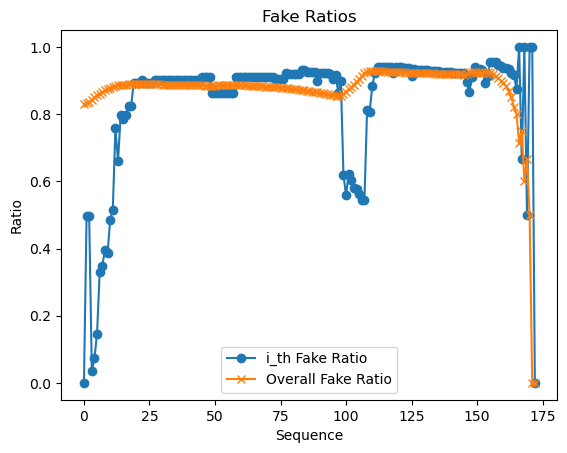

In [52]:
plt.plot(id_gene_df.index, id_gene_df['ith_fake_ratio'], label='i_th Fake Ratio', marker='o')
plt.plot(id_gene_df.index, id_gene_df['overall_fake_ratio'], label='Overall Fake Ratio', marker='x')

# Adding title and labels
plt.title('Fake Ratios')
plt.xlabel('Sequence')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [53]:
id_gene_df['overall_fake_ratio'].describe()

count    173.000000
mean       0.873999
std        0.107370
min        0.000000
25%        0.875964
50%        0.886642
75%        0.919118
max        0.928251
Name: overall_fake_ratio, dtype: float64

In [54]:
id_gene_df['ith_fake_ratio'].describe()

count    173.000000
mean       0.840125
std        0.190001
min        0.000000
25%        0.864865
50%        0.910000
75%        0.925000
max        1.000000
Name: ith_fake_ratio, dtype: float64